In [1]:
from auto_churn.Cleanup import *
from auto_churn.ReportGenerator import *
from auto_churn.FeatureAnalyzer import *
from auto_churn.ModelValidator import *
from auto_churn.ModelOptimizer import *
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### AutoChurn: Dedykowany Pakiet AutoML do rozwiązywania problemów Churnu

AutoChurn to pakiet AutoML zaprojektowany z myślą o wspieraniu użytkowników w procesie analizy i przewidywania churnu klientów.

### Grupa docelowa użytkowników

AutoChurn jest skierowany do trzech głównych grup odbiorców:
1. **Analitycy danych i specjaliści ds. uczenia maszynowego**:
   - Użytkownicy z podstawową lub średnio zaawansowaną wiedzą w zakresie ML, którzy chcą szybko wdrożyć modele predykcyjne bez konieczności ręcznego dostrajania hiperparametrów.
2. **Menedżerowie i specjaliści ds. marketingu**:
   - Osoby odpowiedzialne za strategię utrzymania klientów, które potrzebują intuicyjnych narzędzi do analizy wyników i wizualizacji czynników wpływających na churn przede wszystkim utworzenie schematu podstawowego klienta, kóry może churnować.
3. **Małe i średnie przedsiębiorstwa (SME)**:
   - Firmy, które nie dysponują dużymi i wykwalifikowanymi zespołami technicznymi, ale chcą korzystać z nowoczesnych narzędzi predykcyjnych w celu minimalizowania strat związanych z odpływem klientów.

---

### Specjalizacja narzędzia

AutoChurn koncentruje się na:
- **Predykcji**: Automatyczne budowanie modeli klasyfikacyjnych do przewidywania, czy dany klient odejdzie (churn) lub pozostanie (retencja).
- **Pre processingu**: Automatycznego przygotowanie danych do dalszego modelowania
- **Selekcji cech**: Automatyczne identyfikowanie kluczowych cech wpływających na churn. 
- **Ewaluacji modeli**: Wbudowane metryki, takie jak AUC-ROC, precyzja, czułość czy F1-score, pomagają w ocenie skuteczności modeli.

AutoChurn wspiera użytkowników interpretacji wyników poprzez  wizualizacje oraz generowany raport.

---

### Przegląd istniejących rozwiązań podobnych w założeniach
Pomimo, że problem churnu jest bardzo popularnym problemem w zagadnieniach uczenia maszynowego to autorzy nie byli w stanie znaleźć pakietów
stricte dedykowanych temu problemowi. Istnieje jednak wiele narzędzi uniwersalnych dzięki którym rozwiązywanie problemu churn staję się znaczniełatwiejsze. Należą do nich:
1. **Scikit-learn**:
    - Ogólny pakiet do uczenia maszynowego implementujący modele, które mogą posłużyć do klasyfikacyjnych zadań churn.
2. **H2O.ai**:
    - Platforma AutoML wspierająca automatyczne budowanie modeli.
3. **Lifetimes**:
    - Biblioteka Python dedykowana modelowaniu retencji klientów i analizy czasu życia klienta (CLV).
4. **Retentioneering**:
    - Narzędzie do analizy ścieżek użytkowników.Skupia się na analizie danych ścieżek, ale nie oferuje kompleksowego wsparcia ML

---

### Etap 1 Ładowanie dany
Na tym etapie ładujemy dane oraz określamy, które kolumny powinny zostać usunięte (zazwyczaj mamy na myśli kolumny typu ID, rownumber, surname)
Wybieramy kolumny porządkowe oraz wyznaczamy ich mapowanie. Następnie wywołujemy pipeline, który wykonuje cały preprocessing

In [2]:
data = pd.read_csv('Customer-Churn-Records.csv')
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
ordinal_columns = ['Card Type']
ordinal_mappings = [['SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']]

In [3]:
pipeline, data_post_process = preprocessing_pipeline(data, 'Exited', columns_to_drop=columns_to_drop, ordinal_columns=ordinal_columns, ordinal_mappings=ordinal_mappings, date_columns=None)

2025-01-12 22:31:31,903 - INFO - Rozpoczęcie tworzenia pipeline'u przetwarzania danych.
2025-01-12 22:31:31,906 - INFO - Początkowy kształt danych: (10000, 18)
2025-01-12 22:31:31,906 - INFO - Usuwane kolumny: ['RowNumber', 'CustomerId', 'Surname']
2025-01-12 22:31:31,912 - INFO - Zidentyfikowane cechy numeryczne: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']
2025-01-12 22:31:31,912 - INFO - Zidentyfikowane cechy kategoryczne: ['Geography', 'Gender']
2025-01-12 22:31:31,913 - INFO - Zidentyfikowane cechy porządkowe: ['Card Type']
2025-01-12 22:31:31,913 - INFO - Zidentyfikowane cechy binarne: ['HasCrCard', 'IsActiveMember', 'Complain']
2025-01-12 22:31:31,915 - INFO - Tworzenie pipeline'u przetwarzania danych...
2025-01-12 22:31:31,961 - INFO - Liczba kolumn po przetwarzaniu: 16 (bez kolumny docelowej).
2025-01-12 22:31:31,962 - INFO - Kolumny po przetwarzaniu: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProd

### Etap 2 Selekcja zmiennych
W tym etapie odrzucamy zmienne na podstawie wysokiej korelacji między sobą oraz wyjątkowo małej korelacji z targetem. Generujemy złote zmienne na podstawie najważniejszej zmiennej w modelu oraz wszystkich innych zmiennych przy użyciu operatora mnożenia i dzielenie. Jeśli złota zmienna jest wyraźnie istotna to zostawiamy ją.

In [4]:
feature_analyzer = FeatureAnalyzer(data_post_process, 'Exited')

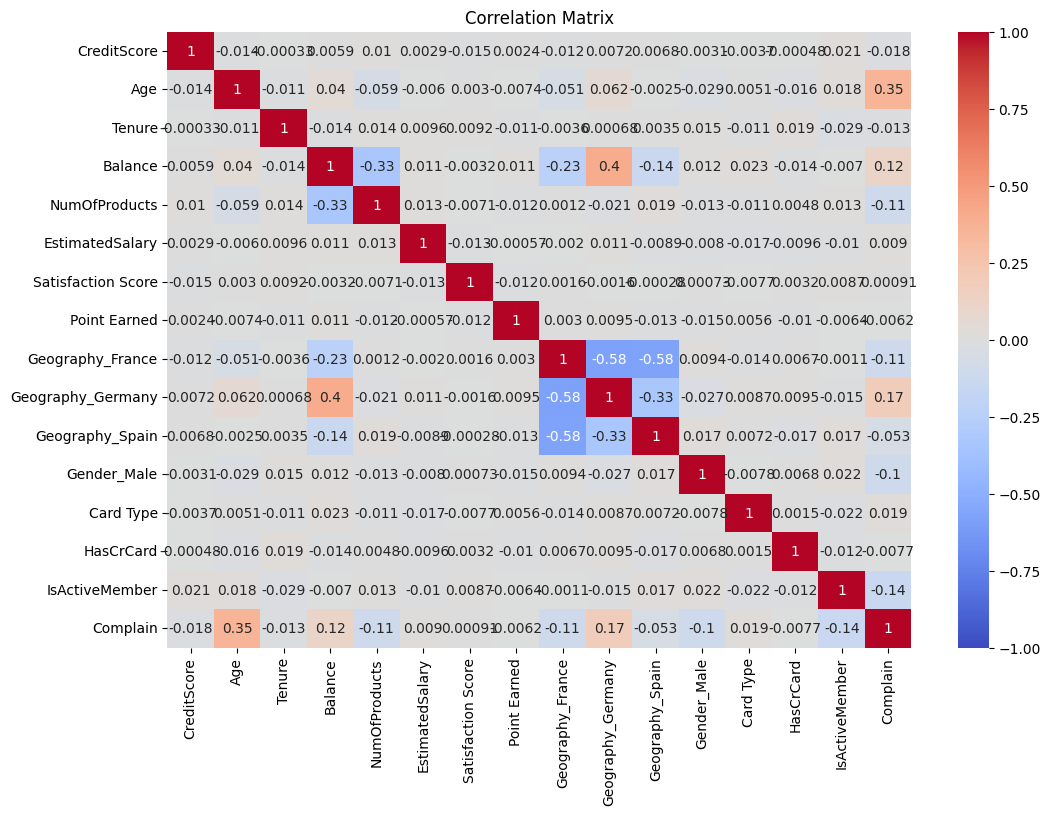

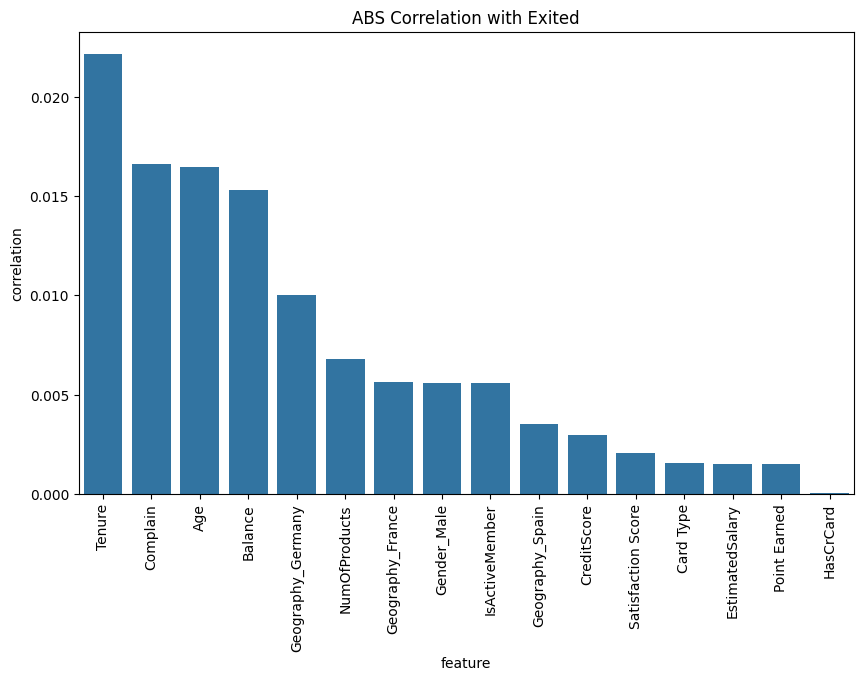

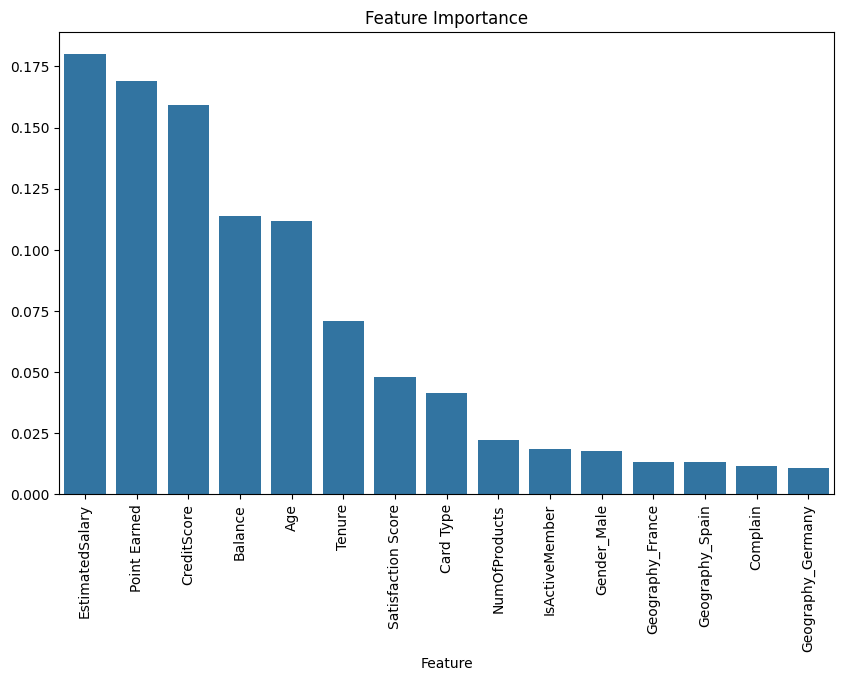

2025-01-12 22:31:46,102 - INFO - Usuwanie kolumn o niskiej korelacji ze zmienną objaśnianą: 1
2025-01-12 22:31:46,103 - INFO - Tworzenie zmiennej golden na podstawie: EstimatedSalary
2025-01-12 22:31:46,104 - INFO - Utworzenie golden features w liczbie: 5
2025-01-12 22:31:46,105 - INFO - Końcowa liczba kolumn: 20


In [5]:
df, high_corr_features, low_corr_with_target, feature_importance, golden_features_df = feature_analyzer.extract_best_features()

### Etap 3 Wybór modelu
Na tym etapie wykonujemy wstępny wybór modelu. Testujemy 6 modeli na bazowych parametrach przy użyciu cross validacji.

In [6]:
model_optimizer = ModelOptimizer(df, 'Exited')

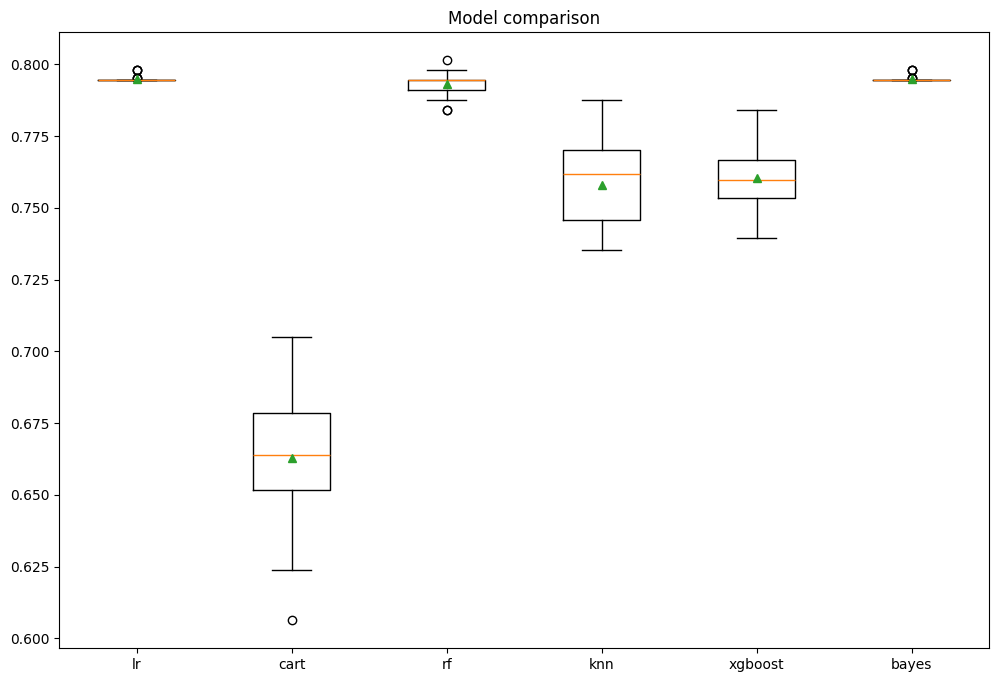

In [9]:
model_optimizer.get_models_candidates()

In [11]:
best_model = model_optimizer.optimize_model('bayes')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


### Etap 4 Raport
Na tym etapie fitujemy zoptymalizowany model oraz generujemy dla niego raport w postaci statystyk oraz Roc plot

In [12]:
model_validator = ModelValidator(df, 'Exited', best_model)

In [13]:
model_validator.fit_model()

{'0': {'precision': 0.7948450017415535, 'recall': 1.0, 'f1-score': 0.8856976518532893, 'support': 2282.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 589.0}, 'accuracy': 0.7948450017415535, 'macro avg': {'precision': 0.39742250087077674, 'recall': 0.5, 'f1-score': 0.44284882592664465, 'support': 2871.0}, 'weighted avg': {'precision': 0.6317785767935301, 'recall': 0.7948450017415535, 'f1-score': 0.7039923516298175, 'support': 2871.0}}
Random (chance) Prediction: AUROC = 0.500
Model: AUROC = 0.485
Model: Gini = -0.030


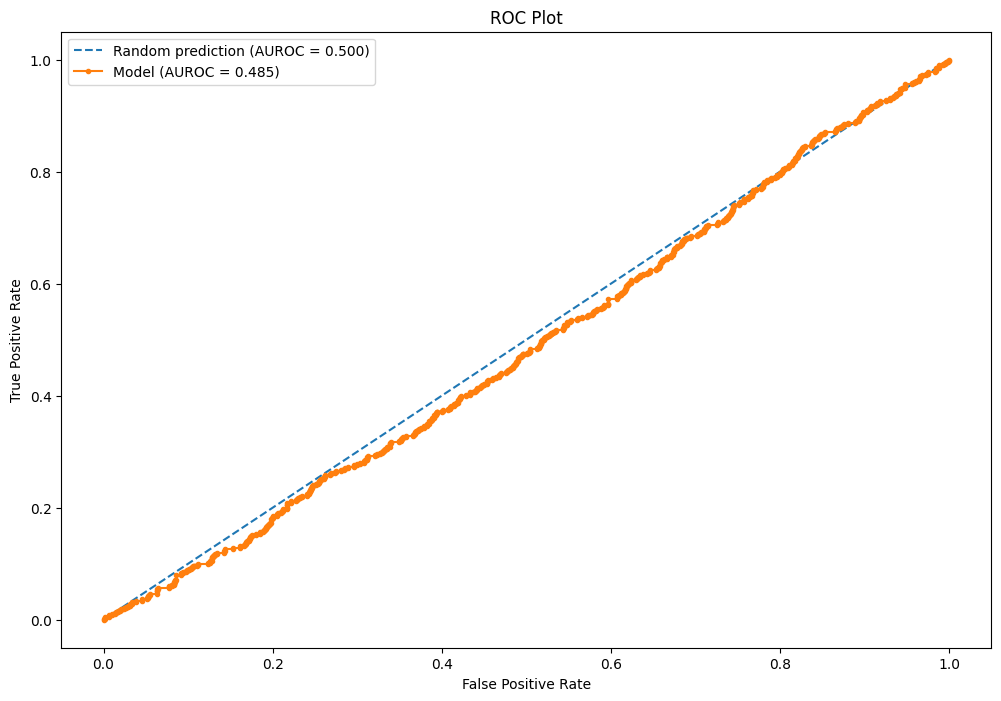

In [14]:
model_validator.get_model_summary()

2025-01-12 22:33:39,041 - INFO - Rozpoczęcie generowania raportu.
2025-01-12 22:33:39,042 - INFO - Eksploracyjna analiza danych (EDA).
2025-01-12 22:33:39,072 - INFO - Podstawowe statystyki danych:
         CreditScore Geography Gender           Age        Tenure  \
count   10000.000000     10000  10000  10000.000000  10000.000000   
unique           NaN         3      2           NaN           NaN   
top              NaN    France   Male           NaN           NaN   
freq             NaN      5014   5457           NaN           NaN   
mean      650.528800       NaN    NaN     38.921800      5.012800   
std        96.653299       NaN    NaN     10.487806      2.892174   
min       350.000000       NaN    NaN     18.000000      0.000000   
25%       584.000000       NaN    NaN     32.000000      3.000000   
50%       652.000000       NaN    NaN     37.000000      5.000000   
75%       718.000000       NaN    NaN     44.000000      7.000000   
max       850.000000       NaN    NaN     9

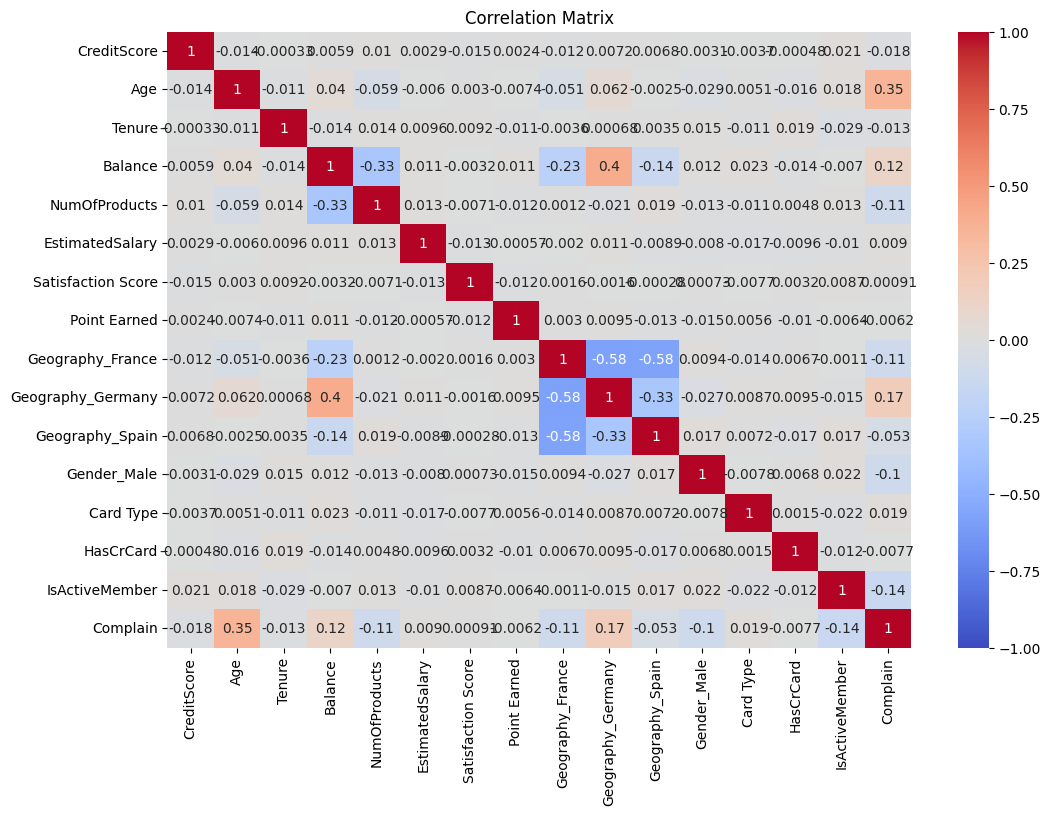

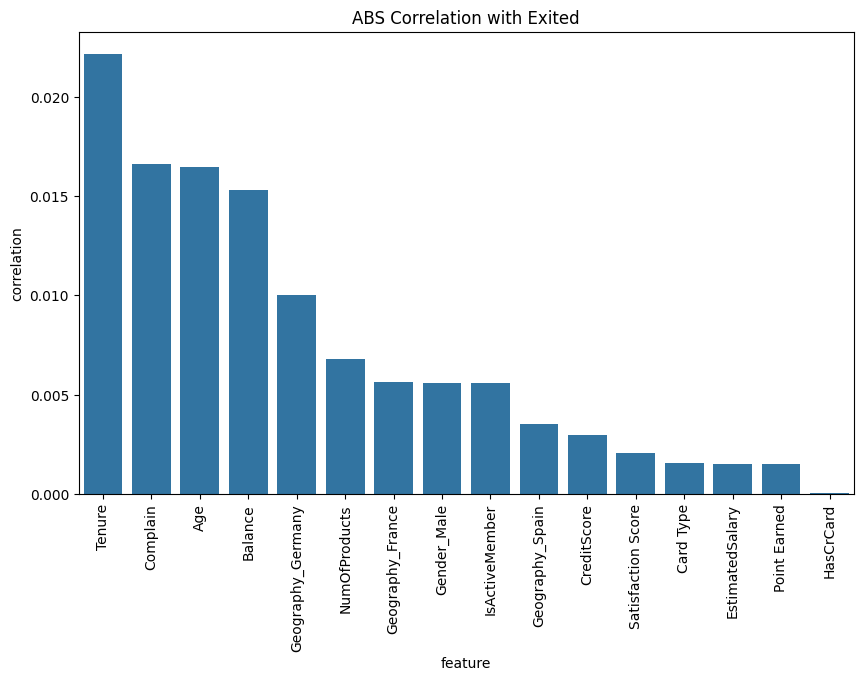

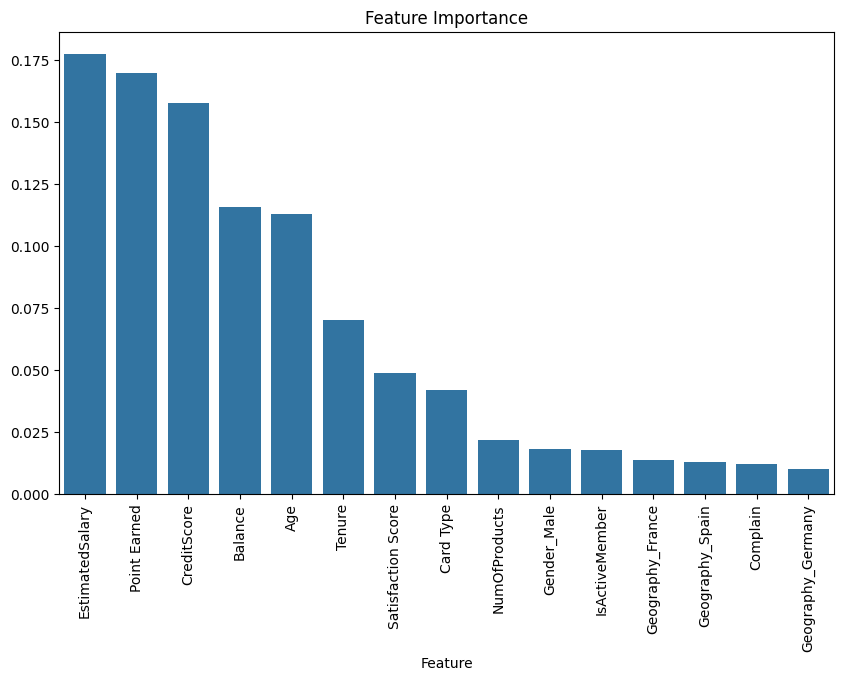

2025-01-12 22:33:50,732 - INFO - Usuwanie kolumn o niskiej korelacji ze zmienną objaśnianą: 1
2025-01-12 22:33:50,733 - INFO - Tworzenie zmiennej golden na podstawie: EstimatedSalary
2025-01-12 22:33:50,734 - INFO - Utworzenie golden features w liczbie: 5
2025-01-12 22:33:50,734 - INFO - Końcowa liczba kolumn: 20
2025-01-12 22:33:50,735 - INFO - Korelacja cech z celem.
2025-01-12 22:33:50,735 - INFO - Generowanie macierzy korelacji.
2025-01-12 22:33:50,736 - INFO - Usunięte cechy o wysokiej korelacji między sobą: ['HasCrCard']
2025-01-12 22:33:50,736 - INFO - Obliczanie ważności cech.
2025-01-12 22:33:50,737 - INFO - Ważności cech:
EstimatedSalary       0.177369
Point Earned          0.169748
CreditScore           0.157789
Balance               0.115740
Age                   0.112960
Tenure                0.070041
Satisfaction Score    0.048789
Card Type             0.041842
NumOfProducts         0.021558
Gender_Male           0.018083
IsActiveMember        0.017747
Geography_France   

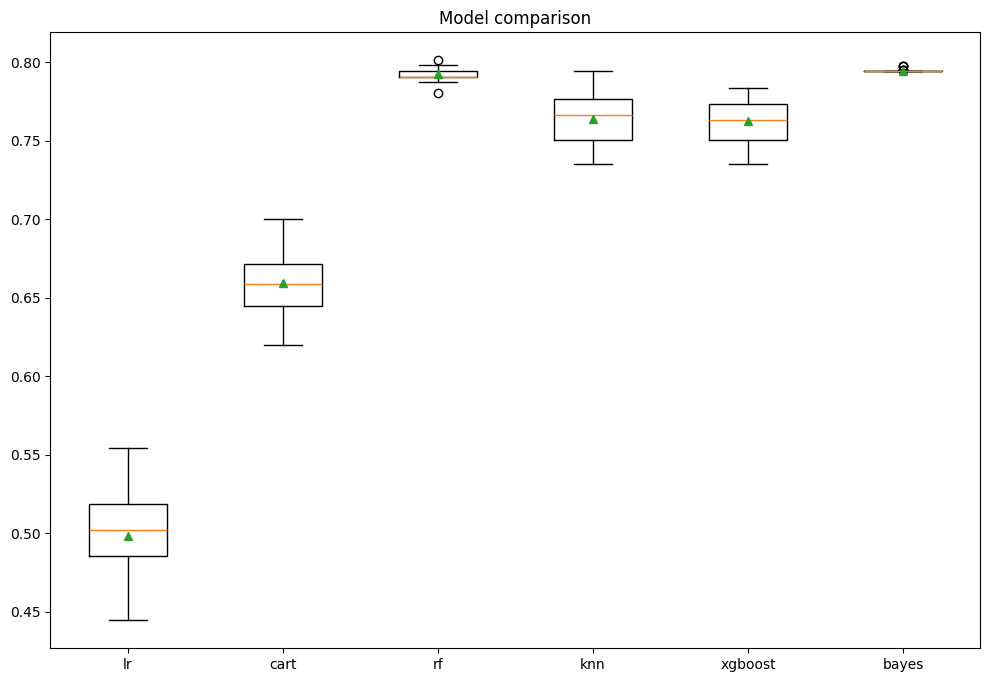

2025-01-12 22:34:05,197 - INFO - Zapisano wykres porównania modeli jako ./figures/boxplot.png.
2025-01-12 22:34:05,198 - INFO - Wybieranie najlepszego modelu na podstawie wyników walidacji.
2025-01-12 22:34:15,399 - INFO - Najlepszy model: bayes z wynikiem 0.7948.
2025-01-12 22:34:15,399 - INFO - Walidacja najlepszego modelu.
2025-01-12 22:34:15,542 - INFO - Generowanie krzywej ROC.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Random (chance) Prediction: AUROC = 0.500
Model: AUROC = 0.481
Model: Gini = -0.039


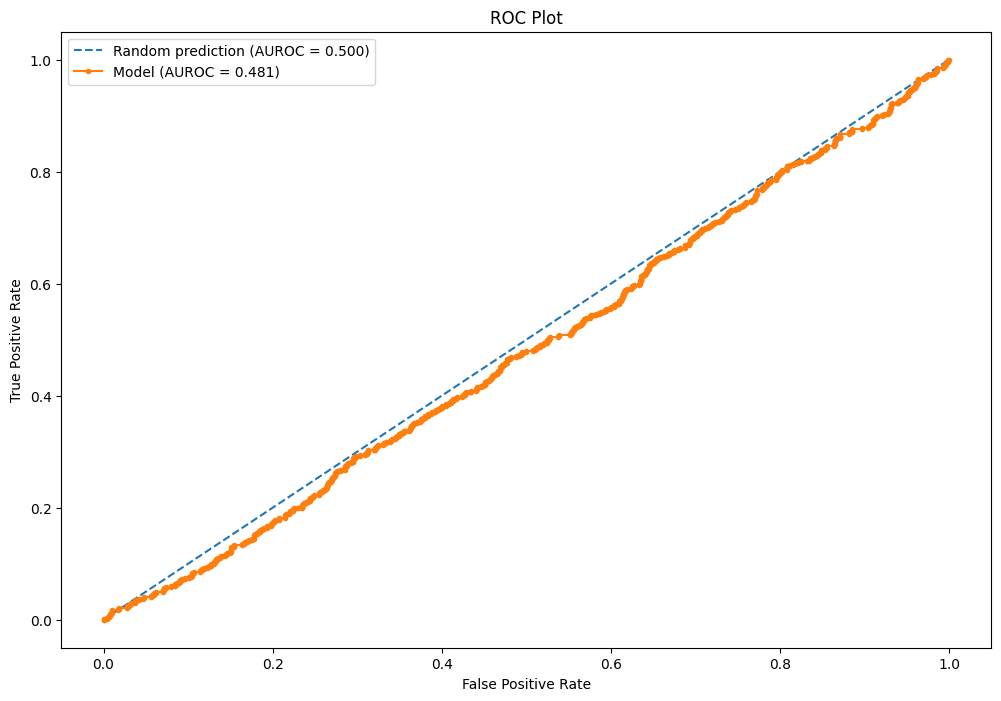

2025-01-12 22:34:15,881 - INFO - Zapisano wykres krzywej ROC jako ./figures/roc_curve.png.
2025-01-12 22:34:15,882 - INFO - Generowanie raportu klasyfikacji.
2025-01-12 22:34:15,893 - INFO - Raport klasyfikacyjny:
{'0': {'precision': 0.7948450017415535, 'recall': 1.0, 'f1-score': 0.8856976518532893, 'support': 2282.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 589.0}, 'accuracy': 0.7948450017415535, 'macro avg': {'precision': 0.39742250087077674, 'recall': 0.5, 'f1-score': 0.44284882592664465, 'support': 2871.0}, 'weighted avg': {'precision': 0.6317785767935301, 'recall': 0.7948450017415535, 'f1-score': 0.7039923516298175, 'support': 2871.0}}


In [15]:
generate_summary_report(df = data_post_process, target_column = 'Exited', original_df = data, columns_to_drop=columns_to_drop,  pipeline = pipeline)